In [6]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import scipy.stats as sts
from scipy.signal import medfilt as mf
import concurrent.futures
import time
import random
import pandas as pd
import seaborn as sns

In [7]:
##########################################################################################
#Parte 1 - Abrindo
##########################################################################################
#Abrindo Simulacao - Módulo de U
I = (np.load('NormU_Re250.npy')[0:448,:,:])**2

I = ( I - I.min() )/I.max()


Imax = I.max()
Imin = I.min()

#Aumentando Volume de Dados da Base
I3D = list(I) 
for i in np.arange(2):
   I3D = I3D + list(I + 0.02*(Imax-Imin)*np.random.randn(I.shape[0],I.shape[1],I.shape[2]) )

I = np.array(I3D)
    
#Mapa 2D + 1D Relativo ao Tempo 
Mapa_ModVel = I.reshape(I.shape[0],420,200) 

#Dados em dimensao Num_Imagens X (LarguraxALtura) - a matriz é flat dado um instante T
ModVel_Flat = I.reshape(I.shape[0],420*200) 

#Reduzindo Tamanho 
ModVel_Flat = I[:, 100:300, 80:120].reshape(I.shape[0],40*200) 


In [8]:
def Calculo(Np,N1,N2,Plot):
    Ruido = 0.2
    ##########################################################################################
    #Parte 2 - Gerando Dados
    ##########################################################################################
    #Selecionando aleatoriamente um instante da simulacao
    T = np.random.randint(0, 448)

    #Selecionando np pontos aleatorios do dominio 
    ModVel_M = np.zeros(Np)      # Np 'Medidas Experimentais'
    Pos_Par  = np.zeros((Np,2))  # Posicao (x,y) das Np Medidas 
    Pos_C    = np.zeros(Np)      # Posicao (x,y) das mesmas Np Medidas para uso na matriz Flat

    for i in np.arange(Np):  
        x_pos = np.random.randint(25, 198)
        y_pos = np.random.randint(0, 40)
        Pos_Par[i]   =  np.array([x_pos,y_pos])

    Pos_C     =  Pos_Par[:,0]*40 + Pos_Par[:,1]
    #ModVel_M  =  ModVel_Flat[T,(Pos_C).astype('int16')] + Ruido*(Imax-Imin)*np.random.randn(1)
    #print(T,ModVel_M)


    ##########################################################################################
    #Parte 3 - Estabelecendo Probabilidades
    ##########################################################################################
    #Gaussiana - p(m|M) 
    def g(x, mu, sig):
        return (1.0/(np.sqrt(2.0 * np.pi) * sig)) * np.exp( -0.5*((x - mu)/sig)**2 )   

    #Definindo posicoes para as quais queremos identificar um valor (excluindo aquelas relativas as medidas já realizadas)
    lista_X = np.arange(ModVel_Flat.shape[1]) 
    mask    = np.isin( lista_X, Pos_C) 
    lista_X = lista_X[~mask]  

    l=lista_X.size
    X =  ModVel_Flat[:,(lista_X).astype('int16')]

    def Roda(LIMITE):
        P_XM = []
        X_restrito = []
        p_mM = 1.0

        Info_Xi =[np.unique( X[:, i], return_counts=True ) for i in range( X.shape[1] ) ]

        #S = np.cov(  ModVel_Flat[:,(Pos_C).astype('int16')].T  )
        #invS = np.linalg.inv(S)
        #det_S = np.linalg.det(S)
        #Norm = 1.0 #/ np.sqrt((2 * np.pi)**Np * det_S)
        #media_t =  ModVel_M 

        for k in np.arange( N1 ):
            Valor = True
            while Valor:
                Pos_C_smpl = np.array( random.sample(sorted(Pos_C), min(N2,Np)) )
                S = np.cov(  ModVel_Flat[:,(Pos_C_smpl).astype('int16')].T  )
                try:
                    invS = np.linalg.inv(S)
                    det_S = np.linalg.det(S)
                    Valor = False
                except:
                    Valor = True
                  
            Norm = 1.0 #/ np.sqrt((2 * np.pi)**Np * det_S)
            media_t =  ModVel_Flat[T,:][(Pos_C_smpl).astype('int16')] 
            
            for t in np.arange(I.shape[0]): 
                x_t =  ModVel_Flat[t,:][(Pos_C_smpl).astype('int16')] + Ruido*(Imax-Imin)*np.random.randn(1)
            
                aux_t = -0.5 * np.dot(np.dot((x_t - media_t).T, invS), (x_t - media_t))
            
                if np.abs(aux_t) < LIMITE:
                    X_row    = ModVel_Flat[t,:][ (lista_X).astype('int16') ]
                    p_Mm_row = Norm*np.exp( aux_t )
                
                    p_XM = p_Mm_row*p_mM

                    P_XM.append(p_XM)
                    X_restrito.append(X_row)
            
        return P_XM, X_restrito

    LIMITE = 3.16
    B = []
    while len(B) < 30:
        A,B = Roda(LIMITE)
        LIMITE = LIMITE*3.16


    def Corrigindo_P(A, B):
        A = np.array(A)
        B = np.array(B)
        PX = []

        for i in range(B.shape[1]):
            M = B[:, i]

            # Criar uma matriz de contagem para cada valor único em M
            unique_vals, counts = np.unique(M, return_counts=True)
            
            # Criar um array de índices para indexação avançada
            indices = np.searchsorted(unique_vals, M)

            # Inicializar uma matriz com zeros para as somas ponderadas
            soma_ponderada = np.zeros_like(unique_vals, dtype=float)

            # Adicionar as somas ponderadas usando indexação avançada
            np.add.at(soma_ponderada, indices, A.astype(float))

            # Criar uma matriz com valores únicos e somas ponderadas
            nova_matriz = np.column_stack((unique_vals, soma_ponderada))

            PX.append(nova_matriz)

        return PX

    P_XM = Corrigindo_P(A,B)

    ##########################################################################################
    #Parte 4 - Reconstruindo
    ##########################################################################################

    P_XM_MAP = np.zeros(l)
    for i in np.arange(l):
        PX = np.array(P_XM[i])
        P_XM_MAP[i] =  PX[np.argmax(PX[:,1]),0]
    Mapa_Recons = P_XM_MAP

    D = P_XM_MAP - ModVel_Flat[T,:][(lista_X).astype('int16')]
    Vmax = np.sort(np.abs(D))[int(len(np.abs(D))*0.95)]


    for k in np.arange(Np):
        Mapa_Recons = np.insert( Mapa_Recons, int(Pos_C[k]), ModVel_M[k]  )
    Mapa_Recons = Mapa_Recons.reshape(200,40)

    ##########################################################################################
    #Parte 5 - Visualizando
    ##########################################################################################
    if Plot :
        plt.figure( figsize=(16,1.8) )

        plt.subplot(131)
        plt.title(f'Escoamento Reconstruido, Np = {Np}')
        plt.pcolormesh( Mapa_Recons.T, cmap='RdBu',vmax=1,vmin=0)
        plt.plot(Pos_Par[:,0]+0.5,Pos_Par[:,1]+0.5,'*g',ms=10,label=f'Posicao Das {Np} Medidas')
        plt.colorbar(orientation='vertical')
        plt.ylim(0,40)
        plt.grid(alpha=0.5)
        plt.legend(fontsize=7,loc=3)
        plt.tight_layout()

        plt.subplot(132)
        plt.title('Escoamento Original')
        plt.pcolormesh( Mapa_ModVel[T,100:300,80:120].T, cmap='RdBu',vmax=1,vmin=0 )
        plt.plot(Pos_Par[:,0]+0.5,Pos_Par[:,1]+0.5,'*g',ms=10,label=f'Posicao Das {Np} Medidas')
        plt.colorbar(orientation='vertical')
        plt.grid(alpha=0.5)
        plt.legend(fontsize=7,loc=3)
        plt.tight_layout()

        plt.subplot(133)
        plt.title('Desvio Absoluto') 
        ear = np.abs(Mapa_Recons.T - Mapa_ModVel[T,100:300,80:120].T  ) 
        mf(ear,kernel_size=11)
        plt.pcolormesh( ear, cmap='RdBu',vmax=Vmax,vmin=0)
        plt.colorbar(orientation='vertical')
        plt.grid(alpha=0.5)
        plt.tight_layout()

    return np.sqrt(  (D**2).sum() )

        


0.9441021427367104

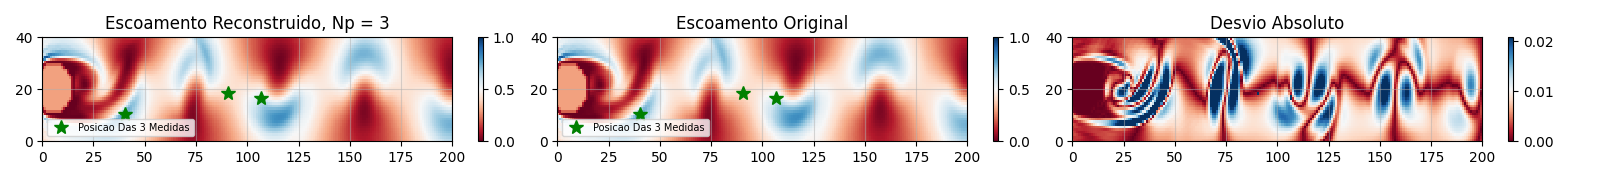

In [9]:
Calculo( 3, 1, 3, True )